# Experiment: Gray–Scott Decorative Moss Pole

**Goal.** Generate a hollow, perforated moss pole using a Gray–Scott reaction–diffusion pattern mapped over a cylinder. Enforce structural integrity by removing any disconnected fragments.

**Specs**
- Outer diameter: **50 mm**
- Wall thickness: **2 mm** (editable)
- Height: **200 mm** (editable)
- Hollow core: yes
- Pattern: Gray–Scott on unwrapped cylindrical domain *(θ × z)*, thresholded to cut through the wall
- Integrity rule: keep only the **largest connected component** (no floating islands)

**Outputs**
- Binary voxel volume ➜ watertight mesh via marching cubes
- Exports: `moss_pole_grayscott.stl` (and optionally `.3mf` if supported)

**Notes**
- Voxel size defaults to **0.5 mm**. Lower it for higher detail, higher cost.
- Gray–Scott parameters *(Du, Dv, F, k, steps)* are exposed for tuning.
- The drilling mask spans the **full wall thickness**, ensuring through-holes.


In [ ]:
# Cell 1: Install required packages first
!pip install numpy scipy scikit-image trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 39.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]


In [40]:
# Cell 2: Import libraries and define parameters

import numpy as np
from scipy.ndimage import label, generate_binary_structure, binary_erosion, binary_dilation, convolve
from skimage import measure
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

try:
    import trimesh
except Exception:
    print("Warning: trimesh not available - mesh export will be skipped")
    trimesh = None

# ----------------------- Parameters -----------------------
outer_d_mm   = 50.0           # outer diameter
wall_mm      = 2.0            # wall thickness
height_mm    = 200.0          # cylinder height
voxel_mm     = 0.5            # voxel size (cube edge length)
min_wall_mm  = 1.0            # minimum wall thickness
drill_width_mm = 1.0          # drill width in mm

# Parameters for brain coral-like patterns
Du, Dv       = 0.2, 0.1      # Higher diffusion for more spread
F, k         = 0.054, 0.064  # Feed/kill for labyrinthine patterns
steps        = 12000         # More steps for pattern development
seed_count   = 6             # Fewer but larger seeds
theta_wrap   = True          
threshold_v  = 0.25          # Lower threshold for wider connections

rng_seed     = 42             # reproducible randomness

# ----------------------- Helpers --------------------------
def gray_scott_2d(nx, ny, steps, Du, Dv, F, K, rng_seed=0, n_seeds=6):
    """
    Classic Gray-Scott on a 2D grid.
    Returns U, V in [0,1].
    """
    np.random.seed(rng_seed)
    
    # Initialize with full U, no V
    U = np.ones((ny, nx))
    V = np.zeros((ny, nx))
    
    # Random seed points
    for _ in range(n_seeds):
        x = np.random.randint(nx)
        y = np.random.randint(ny)
        V[y-3:y+3, x-3:x+3] = 1.0
    
    # Simulation loop
    for _ in range(steps):
        # Compute Laplacians
        Lu = np.roll(U, 1, 0) + np.roll(U, -1, 0) + np.roll(U, 1, 1) + np.roll(U, -1, 1) - 4*U
        Lv = np.roll(V, 1, 0) + np.roll(V, -1, 0) + np.roll(V, 1, 1) + np.roll(V, -1, 1) - 4*V
        
        # Update rules
        uvv = U * V * V
        U += Du * Lu - uvv + F * (1 - U)
        V += Dv * Lv + uvv - (F + K) * V
    
    return U, V

def check_connectivity(binary_vol, min_connections=3, preserve_boundary=True):
    """
    Check if all solid voxels have at least min_connections neighbors.
    Returns cleaned volume with unsafe voxels removed.
    """
    struct = generate_binary_structure(3, 3)
    
    # Count neighbors for each voxel
    neighbor_count = convolve(
        binary_vol.astype(float), 
        struct.astype(float),
        mode='constant'
    )
    
    # Keep only voxels with sufficient connections
    return binary_vol & (neighbor_count >= min_connections)

def largest_component_only(binary_vol):
    """
    Keep only the largest 26-connected component in a 3D binary volume.
    """
    structure = np.ones((3,3,3), dtype=np.uint8)
    labeled, n = label(binary_vol, structure=structure)
    if n <= 1:
        return binary_vol
    # Find the label with max voxel count (exclude 0)
    counts = np.bincount(labeled.ravel())
    counts[0] = 0
    keep_label = counts.argmax()
    return (labeled == keep_label)

def ensure_wall_thickness(binary_vol, min_thickness_mm, voxel_mm):
    """
    Ensure minimum wall thickness through a conservative morphological operation.
    Previous erosion-then-dilation removed thin structures entirely; use dilation-only
    to thicken existing walls to the target minimum without deleting geometry.
    """
    # compute required voxel padding to reach target thickness (ceil)
    min_wall_voxels = max(1, int(np.ceil(min_thickness_mm / voxel_mm)))
    struct = np.ones((3,3,3), dtype=bool)
    # Only dilate (conservative) to increase thickness; avoid prior erosion
    return binary_dilation(binary_vol, structure=struct, iterations=min_wall_voxels)

# Grid setup
def create_cylindrical_grid():
    # Convert mm to voxels
    outer_r = int(outer_d_mm / (2 * voxel_mm))
    wall_voxels = max(2, int(wall_mm / voxel_mm))
    inner_r = outer_r - wall_voxels
    height = int(height_mm / voxel_mm)
    
    # Cylindrical grid dimensions
    circ = int(2 * np.pi * outer_r)  # unwrapped circumference in voxels
    nx, ny, nz = circ, height, outer_r * 2 + 1
    
    # Create hollow cylinder: compute a single radial cross-section (nz × nx)
    # Z,X from ogrid produce shapes (1,nz,1) and (1,1,nx) so dist2d is (1,nz,nx)
    _, Z, X = np.ogrid[:1, :nz, :nx]
    center_z = nz // 2
    dist2d = np.sqrt((Z - center_z)**2 + (X - nx//2)**2)  # shape (1, nz, nx)
    cross = (dist2d <= outer_r) & (dist2d >= inner_r)     # shape (1, nz, nx)
    
    # Repeat the same cross-section along the height to get (ny, nz, nx)
    shell = np.repeat(cross, ny, axis=0)
    
    return shell, (nx, ny, nz)

# Create base cylinder and run Gray-Scott
shell, (nx, ny, nz) = create_cylindrical_grid()
U, V = gray_scott_2d(nx, ny, steps, Du, Dv, F, k, rng_seed, seed_count)

# Map pattern to cylinder - FIXED VERSION
carved = shell.copy()
pattern = V > threshold_v

# Create a drilling mask aligned with shell dimensions using safe broadcasting
# pattern has shape (ny, nx) -> pattern[:, None, :] has shape (ny, 1, nx)
# repeating along axis=1 yields (ny, nz, nx) to match shell
drilling_mask = np.repeat(pattern[:, np.newaxis, :], nz, axis=1)

# Apply the drilling pattern
carved = shell & ~drilling_mask

# Apply structural constraints
carved_cc = largest_component_only(carved)
carved_cc = check_connectivity(carved_cc, min_connections=3)
carved_cc = ensure_wall_thickness(carved_cc, min_wall_mm, voxel_mm)

In [41]:
# Cell 3: Generate pattern and create mesh

# Create base cylinder
shell, (nx, ny, nz) = create_cylindrical_grid()

# Run Gray-Scott simulation
print("Running Gray-Scott simulation...")
U, V = gray_scott_2d(nx, ny, steps, Du, Dv, F, k, rng_seed, seed_count)

# Map pattern to cylinder
print("Mapping pattern to cylinder...")
carved = shell.copy()
pattern = V > threshold_v
print(f"Pattern shape: {pattern.shape}, Shell shape: {shell.shape}")
print("Pattern stats:", pattern.sum(), "/", pattern.size)

# --- build robust 2D drilling mask from skeletonized pattern ---
# 1) Skeletonize pattern (ny, nx)
skel = skeletonize(pattern)  # boolean 2D

# 2) Remove pure cycles (connected skeleton components without endpoints)
nbr2d = convolve(skel.astype(int), np.ones((3,3)), mode='constant') - skel.astype(int)
endpoints = (skel & (nbr2d == 1))
labeled_skel, n_comp = label(skel, structure=np.ones((3,3)))
for lab in range(1, n_comp+1):
    comp = (labeled_skel == lab)
    if not (comp & endpoints).any():
        # pure cycle → remove it to avoid closed-ring drilling
        skel[comp] = False

# 3) Dilate skeleton to desired drill width (in voxels)
drill_vox = max(1, int(round(drill_width_mm / voxel_mm)))
struct2d = np.ones((2*drill_vox + 1, 2*drill_vox + 1), dtype=bool)
skel_dil = binary_dilation(skel, structure=struct2d)

# 4) Broadcast 2D drill mask through radial axis (ny, nz, nx)
drilling_mask_2d = skel_dil  # shape (ny, nx)
drilling_mask = np.repeat(drilling_mask_2d[:, np.newaxis, :], shell.shape[1], axis=1)

# Apply drilling to shell
carved = shell & ~drilling_mask
print("Initial carving (voxels):", carved.sum(), "/", carved.size)

# Apply structural constraints
carved_cc = largest_component_only(carved)
print(f"After connected components: {carved_cc.sum():,} solid voxels")

carved_cc = check_connectivity(carved_cc, min_connections=3)
carved_cc = ensure_wall_thickness(carved_cc, min_wall_mm, voxel_mm)
print(f"After constraints: {carved_cc.sum():,} solid voxels")

# Generate mesh
if trimesh is not None and carved_cc.sum() > 0:
    print("\nGenerating mesh...")
    volume = carved_cc.astype(float)
    
    print(f"Volume stats:")
    print(f"- Shape: {volume.shape}")
    print(f"- Range: [{volume.min():.1f}, {volume.max():.1f}]")
    print(f"- Non-zero voxels: {np.count_nonzero(volume):,}")
    
    try:
        verts, faces, normals, _ = measure.marching_cubes(
            volume,
            level=0.5,
            spacing=(voxel_mm, voxel_mm, voxel_mm),
            allow_degenerate=False
        )
        
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=True)
        mesh.export('moss_pole_grayscott.stl')
        print(f"\nExported mesh with {len(mesh.vertices):,} vertices")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nTrying with different volume preparation...")
        # Try with inverted and padded volume
        volume = np.pad(~carved_cc, 1, mode='constant')
        verts, faces, _, _ = measure.marching_cubes(
            volume.astype(float),
            level=0.5,
            spacing=(voxel_mm, voxel_mm, voxel_mm)
        )
        mesh = trimesh.Trimesh(vertices=verts, faces=faces)
        mesh.export('moss_pole_grayscott.stl')
        print("✓ Export successful with alternate method")
else:
    print("× Skipping mesh generation - no volume data")

Running Gray-Scott simulation...
Mapping pattern to cylinder...
Pattern shape: (400, 314), Shell shape: (400, 101, 314)
Pattern stats: 5816 / 125600
Initial carving (voxels): 488504 / 12685600
After connected components: 488,504 solid voxels
Mapping pattern to cylinder...
Pattern shape: (400, 314), Shell shape: (400, 101, 314)
Pattern stats: 5816 / 125600
Initial carving (voxels): 488504 / 12685600
After connected components: 488,504 solid voxels
After constraints: 1,080,510 solid voxels

Generating mesh...
Volume stats:
- Shape: (400, 101, 314)
- Range: [0.0, 1.0]
- Non-zero voxels: 1,080,510
After constraints: 1,080,510 solid voxels

Generating mesh...
Volume stats:
- Shape: (400, 101, 314)
- Range: [0.0, 1.0]
- Non-zero voxels: 1,080,510

Exported mesh with 277,939 vertices

Exported mesh with 277,939 vertices


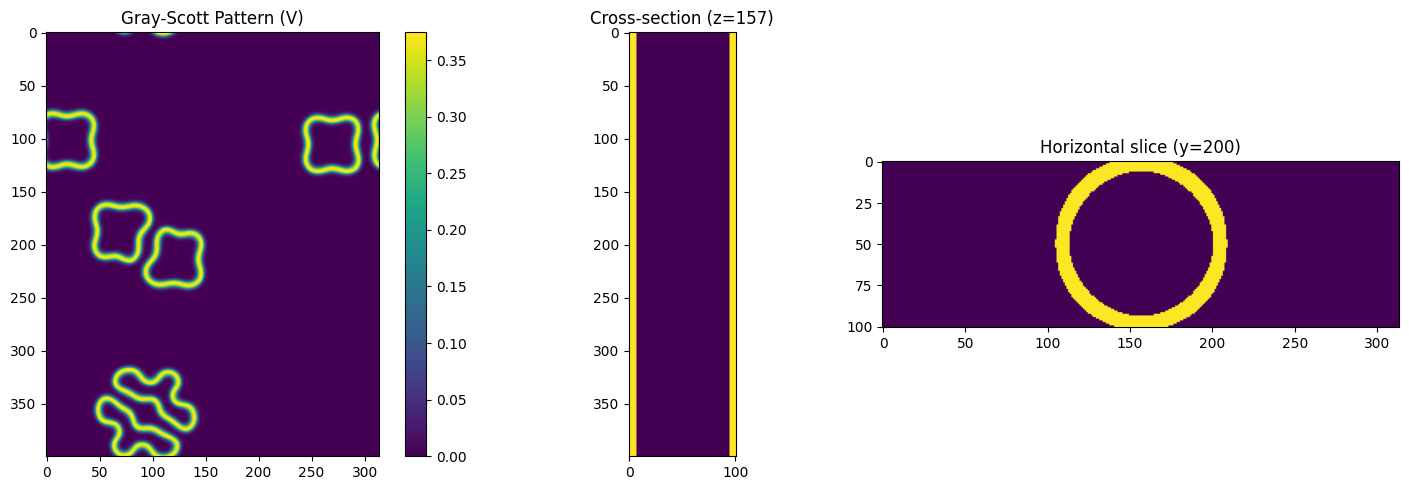


Stats:
Solid voxels: 1,080,510 / 489,600
Open fraction: -120.7%


In [43]:
# Cell 4: Visualization

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(V, cmap='viridis')
plt.title('Gray-Scott Pattern (V)')
plt.colorbar()

plt.subplot(132)
slice_z = carved_cc.shape[2]//2
plt.imshow(carved_cc[:, :, slice_z])
plt.title(f'Cross-section (z={slice_z})')

plt.subplot(133)
slice_y = carved_cc.shape[0]//2
plt.imshow(carved_cc[slice_y])
plt.title(f'Horizontal slice (y={slice_y})')

plt.tight_layout()
plt.show()

# Print stats
solid_voxels = carved_cc.sum()
total_voxels = shell.sum()
print(f"\nStats:")
print(f"Solid voxels: {solid_voxels:,} / {total_voxels:,}")
print(f"Open fraction: {1 - solid_voxels/total_voxels:.1%}")